<a href="https://colab.research.google.com/github/wonjsohn/kinadaptive/blob/main/arduino_tinyml_workshop_WJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://www.arduino.cc/"><img src="https://raw.githubusercontent.com/sandeepmistry/aimldevfest-workshop-2019/master/images/Arduino_logo_R_highquality.png" width=200/></a>
# Tiny ML on Arduino
## Gesture recognition tutorial
 * Sandeep Mistry - Arduino
 * Don Coleman - Chariot Solutions


https://github.com/arduino/ArduinoTensorFlowLiteTutorials/

## Setup Python Environment

The next cell sets up the dependencies in required for the notebook, run it.

In [27]:
# Setup environment
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install tensorflow

# Upload Data

1. Open the panel on the left side of Colab by clicking on the __>__
1. Select the files tab
1. Drag `punch.csv` and `flex.csv` files from your computer to the tab to upload them into colab.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
! pip install -q tensorflow-model-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 4.4 MB/s eta 0:00:00


In [11]:
import tempfile
from tensorflow_model_optimization.python.core.keras.compat import keras

%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Graph Data (optional)

We'll graph the input files on two separate graphs, acceleration and gyroscope, as each data set has different units and scale.

<ipython-input-3-915bc0620dfb>:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
<ipython-input-3-915bc0620dfb>:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "b." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
<ipython-input-3-915bc0620dfb>:18: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')


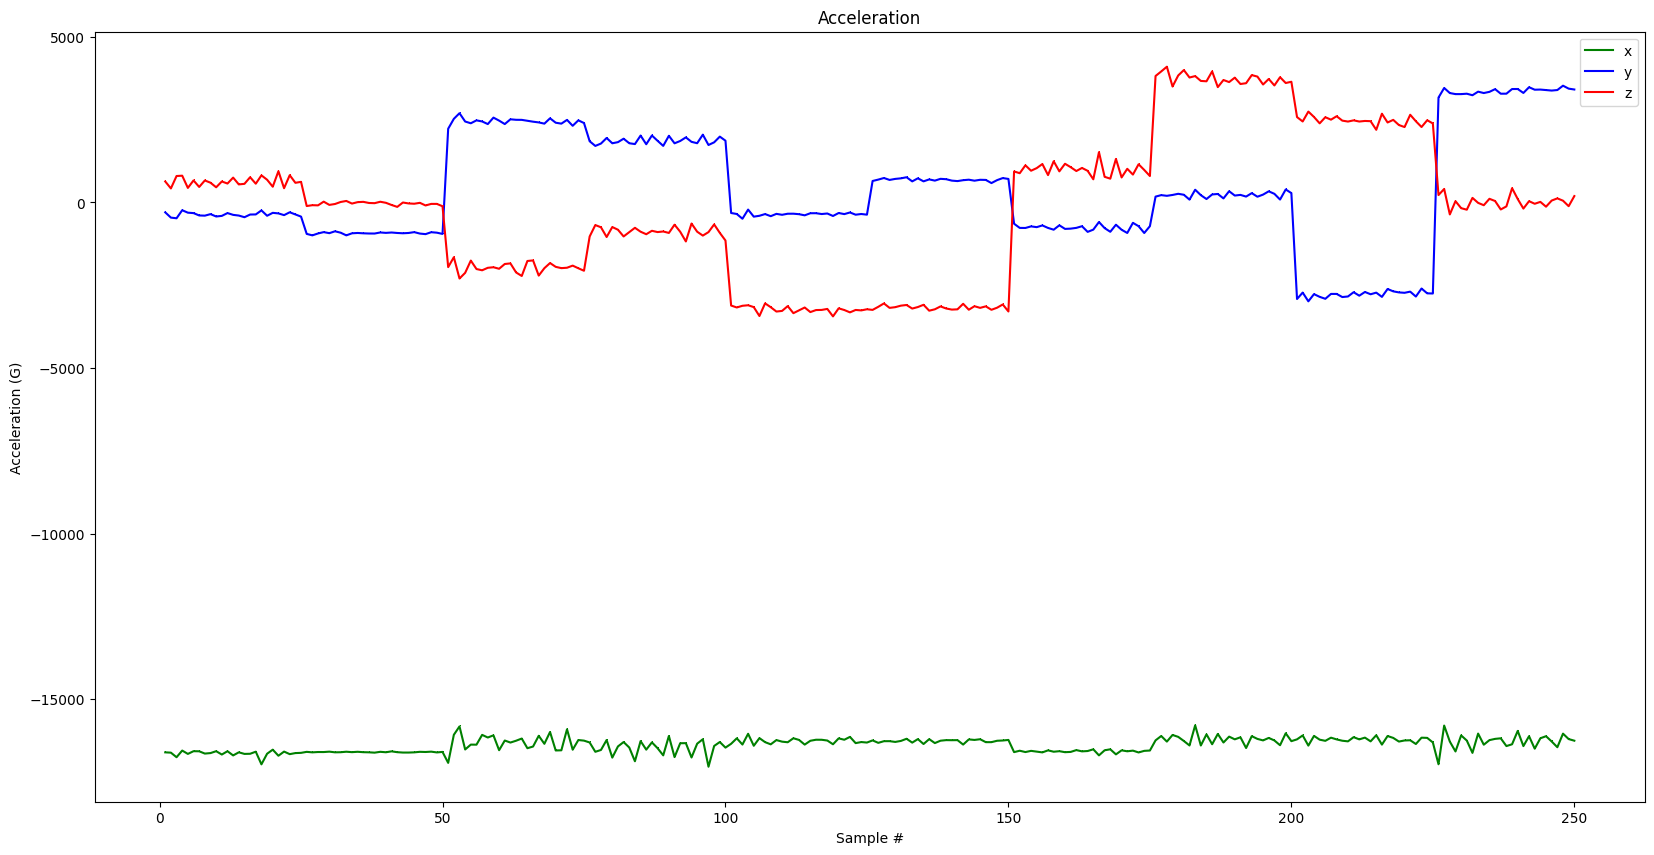

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



filename = "stand.csv"
dataRoot = "/content/drive/MyDrive/arduino_tinyml_gdrive/20241017/25Hz/csv_files/"

df = pd.read_csv(dataRoot + filename)

index = range(1, len(df['aX']) + 1)

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

# plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
# plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
# plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')
# plt.title("Gyroscope")
# plt.xlabel("Sample #")
# plt.ylabel("Gyroscope (deg/sec)")
# plt.legend()
# plt.show()


In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.decomposition import  PCA
from sklearn import preprocessing
from sklearn import tree
from sklearn.manifold import TSNE
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import metrics

from sklearn.model_selection import train_test_split

# Train Neural Network





## Parse and prepare the data

The next cell parses the csv files and transforms them to a format that will be used to train the fully connected neural network.

Update the `GESTURES` list with the gesture data you've collected in `.csv` format.


In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1336
np.random.seed(SEED)
tf.random.set_seed(SEED)

dataRoot = "/content/drive/MyDrive/arduino_tinyml_gdrive/20241017/25Hz/csv_files/"

# the list of gestures that data is available for
GESTURES = [
    # "currentup",
    # "currentdown",
    # "wakeup",
    # "toggle",
    # "turnoff",
    #"heelTap",
    #"prone",
    #"sit2prone",
    #"sit2stand",
    #"sit2supine",
    # "stand2sit",  # adding stand2sit significantly reduced performance!
    # "standing",
    #"supine",
    #"waistCircular",
    # "walk60",
    #"prone",
    #"sit2stand",
    #"stand2sit",
    #"supine",
    #"standing",
    #"turnright",
    #"walk60",
    # "prone_3dof",
    # "supine_3dof",
    # "standing_3dof",  # per 9/5 request from Jacob,  three class model "prone, supine, standing"
    # "prone_3dof",
    # "stand_3dof",
    # "supine_3dof",
    # per 9/5 request from Jacob,  three class model "prone, supine, standing"
    # "prone",    # 0909_2
    # # "run",
    # "stand2sit", # 0909_2
    # "supine",     # 0909_2
    # "walk",       # 0909_2
    "prone",   #1017
    "sideR",   #1017
    "stand",   #1017
    "supine",   #1017
]
# idle: hand down and do nothing.
# tremor:  4 Hz movement in any direction.
# Do they work while walking? In bed?

SAMPLES_PER_GESTURE = 25 # 25 Hz = 25,  SET THIS CORREECTLY!   119  #240  #was 119 for 1second before

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")

  output = ONE_HOT_ENCODED_GESTURES[gesture_index]

  df = pd.read_csv(dataRoot + gesture + ".csv", skip_blank_lines=True)



  print("Df shape 0: ", df.shape[0])

  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)

  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")

  for i in range(num_recordings):

    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      # tensor += [
      #     (df['aX'][index] + 4) / 8,
      #     (df['aY'][index] + 4) / 8,
      #     (df['aZ'][index] + 4) / 8,
      #     (df['gX'][index] + 2000) / 4000,
      #     (df['gY'][index] + 2000) / 4000,
      #     (df['gZ'][index] + 2000) / 4000
      # ]

      # 20240827, floating point
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -32 to +32
      # - gyroscope is between: -2000 to +2000
      # tensor += [
      #     (df['aX'][index] + 32) / 64,
      #     (df['aY'][index] + 32) / 64,
      #     (df['aZ'][index] + 32) / 64,
      #     (df['gX'][index] + 2000) / 4000,
      #     (df['gY'][index] + 2000) / 4000,
      #     (df['gZ'][index] + 2000) / 4000
      # ]
      #------- update for raw data  ------#
      # 20241017
      tensor += [
          (df['aX'][index] + 32768) / 65536,
          (df['aY'][index] + 32768) / 65536,
          (df['aZ'][index] + 32768) / 65536
          # (df['gX'][index] + 32768) / 65536,
          # (df['gY'][index] + 32768) / 65536,
          # (df['gZ'][index] + 32768) / 65536
      ]


    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

TensorFlow version = 2.17.0

Processing index 0 for gesture 'prone'.
Df shape 0:  250
	There are 10 recordings of the prone gesture.
Processing index 1 for gesture 'sideR'.
Df shape 0:  250
	There are 10 recordings of the sideR gesture.
Processing index 2 for gesture 'stand'.
Df shape 0:  250
	There are 10 recordings of the stand gesture.
Processing index 3 for gesture 'supine'.
Df shape 0:  250
	There are 10 recordings of the supine gesture.
Data set parsing and preparation complete.


In [61]:
inputs.shape

(40, 75)

## Randomize and split the input and output pairs for training

Randomly split input and output pairs into sets of data: 60% for training, 20% for validation, and 20% for testing.

  - the training set is used to train the model
  - the validation set is used to measure how well the model is performing during training
  - the testing set is used to test the model after training

In [62]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
rand_inputs = inputs[randomize]
rand_outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(rand_inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(rand_outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


In [25]:
num_inputs

40

# Exploratory data anaylsis
## Which sensor is more important for classification?


## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

In [63]:
#pruning related test
import tf_keras as keras

In [64]:
# modified to use tf_keras

# build the model and train it
# layer 1: 50, layer 2: 15
model0 = keras.Sequential()
model0.add(keras.layers.Dense(35, activation='relu')) # relu is used for performance
model0.add(keras.layers.Dense(15, activation='relu'))   # 20?
model0.add(keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model0.compile(optimizer='rmsprop', loss='mae', metrics=['mae']) # I may have used this for 0827 6 class ok result.
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model0.fit(inputs_train, outputs_train, epochs=100, batch_size=1, validation_data=(inputs_validate, outputs_validate))



Epoch 1/100
24/24 [==============================] - 1s 11ms/step - loss: 0.3748 - mae: 0.3748 - val_loss: 0.3528 - val_mae: 0.3528
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 0.3540 - mae: 0.3540 - val_loss: 0.3451 - val_mae: 0.3451
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 0.3447 - mae: 0.3447 - val_loss: 0.3407 - val_mae: 0.3407
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 0.3352 - mae: 0.3352 - val_loss: 0.3371 - val_mae: 0.3371
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 0.3281 - mae: 0.3281 - val_loss: 0.3310 - val_mae: 0.3310
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 0.3190 - mae: 0.3190 - val_loss: 0.3272 - val_mae: 0.3272
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 0.3082 - mae: 0.3082 - val_loss: 0.3207 - val_mae: 0.3207
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 0.2996 - 

In [48]:
# build the model and train it
# layer 1: 50, layer 2: 15
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))   # 20?
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='rmsprop', loss='mae', metrics=['mae']) # I may have used this for 0827 6 class ok result.
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(inputs_train, outputs_train, epochs=100, batch_size=1, validation_data=(inputs_validate, outputs_validate))



Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.3892 - mae: 0.3892 - val_loss: 0.3543 - val_mae: 0.3543
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3699 - mae: 0.3699 - val_loss: 0.3504 - val_mae: 0.3504
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3638 - mae: 0.3638 - val_loss: 0.3466 - val_mae: 0.3466
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3587 - mae: 0.3587 - val_loss: 0.3395 - val_mae: 0.3395
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3477 - mae: 0.3477 - val_loss: 0.3322 - val_mae: 0.3322
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3364 - mae: 0.3364 - val_loss: 0.3251 - val_mae: 0.3251
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3252 - mae: 0.3252 - val_loss: 0.3158 - val_mae: 0.3158
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3105 - mae: 0.3105 - val_loss: 0.3054 - val_mae: 0.3054
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0

In [65]:
model0.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (1, 35)                   2660      
                                                                 
 dense_4 (Dense)             (1, 15)                   540       
                                                                 
 dense_5 (Dense)             (1, 4)                    64        
                                                                 
Total params: 3264 (12.75 KB)
Trainable params: 3264 (12.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
# Helper function uses `prune_low_magnitude` to make only the
# Dense layers train with pruning.

def apply_pruning_to_dense(layer):
  if isinstance(layer, keras.layers.Dense):
    return tfmot.sparsity.keras.prune_low_magnitude(layer)
  return layer

# Use `keras.models.clone_model` to apply `apply_pruning_to_dense`
# to the layers of the model.
model_for_pruning = keras.models.clone_model(
    model0,
    clone_function=apply_pruning_to_dense,
)

model_for_pruning.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_dense   (1, 50)                   7552      
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_dense_  (1, 15)                   1517      
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense_  (1, 4)                    126       
 2 (PruneLowMagnitude)                                           
                                                                 
Total params: 9195 (35.93 KB)
Trainable params: 4629 (18.08 KB)
Non-trainable params: 4566 (17.85 KB)
_________________________________________________________________


In [56]:
import tensorflow_model_optimization as tfmot
import tensorflow as tf

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Define the pruning schedule
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.5,
        final_sparsity=0.80,  # Adjust as needed
        begin_step=0,
        end_step=2000  # Adjust based on dataset size and epochs
    )
}

model_for_pruning = prune_low_magnitude(model0, **pruning_params)


# Recompile the pruned model
model_for_pruning.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])



# Print the model summary
model_for_pruning.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_dense   (1, 50)                   7552      
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_dense_  (1, 15)                   1517      
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense_  (1, 4)                    126       
 2 (PruneLowMagnitude)                                           
                                                                 
Total params: 9195 (35.93 KB)
Trainable params: 4629 (18.08 KB)
Non-trainable params: 4566 (17.85 KB)
_________________________________________________________________


### Modeling many models (Non-keras)

## Verify

Graph the models performance vs validation.


### Graph the loss

Graph the loss to see when the model stops improving.

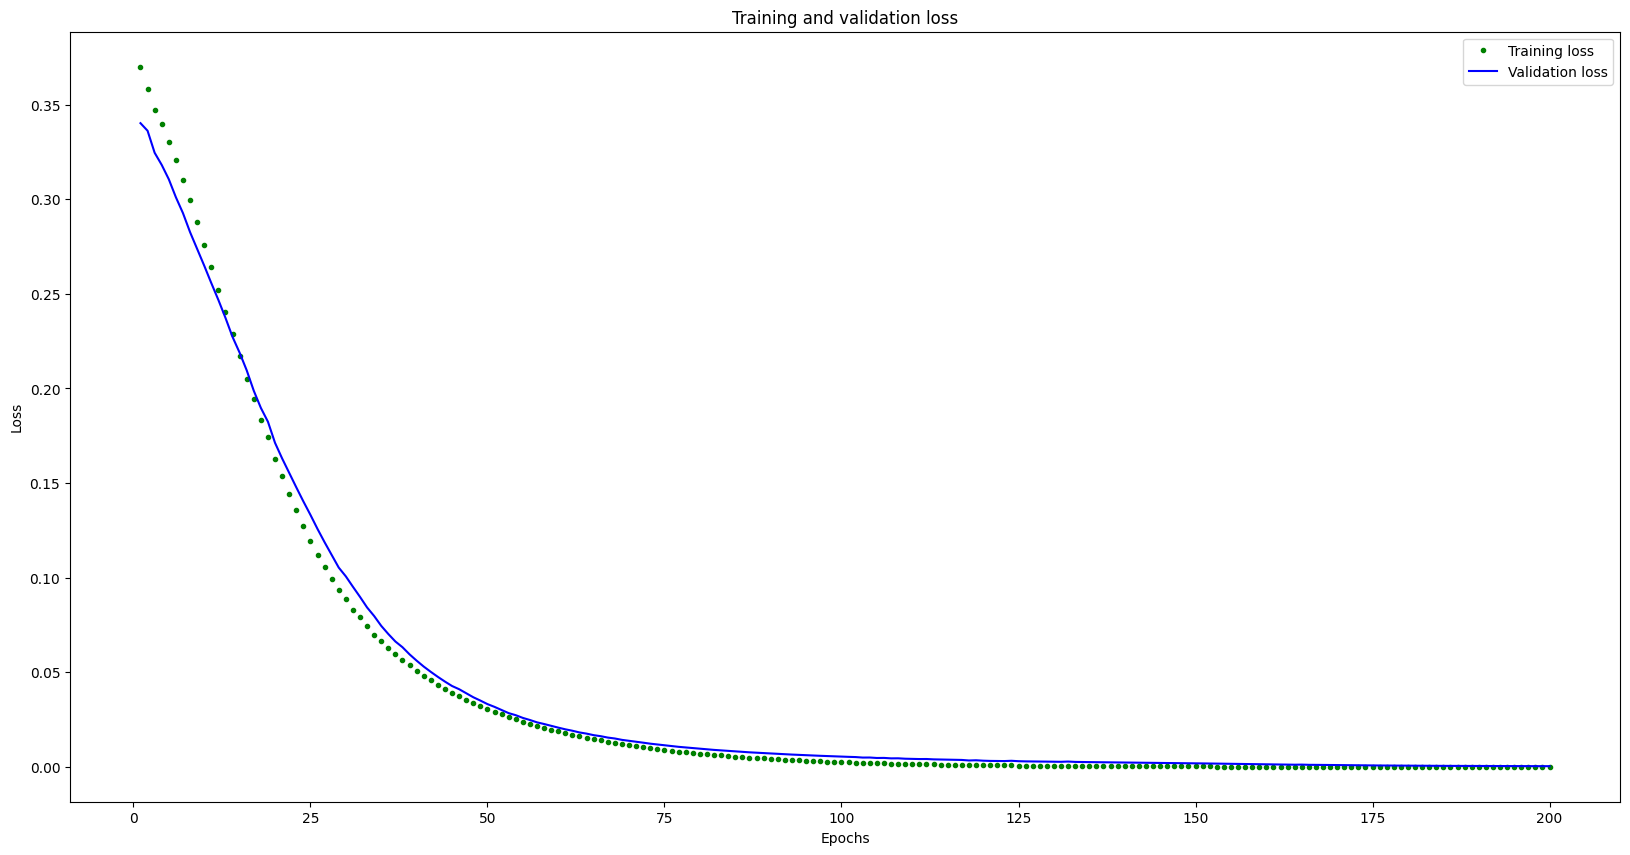

[20.0, 10.0]


In [8]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

### Graph the loss again, skipping a bit of the start

We'll graph the same data as the previous code cell, but start at index 100 so we can further zoom in once the model starts to converge.

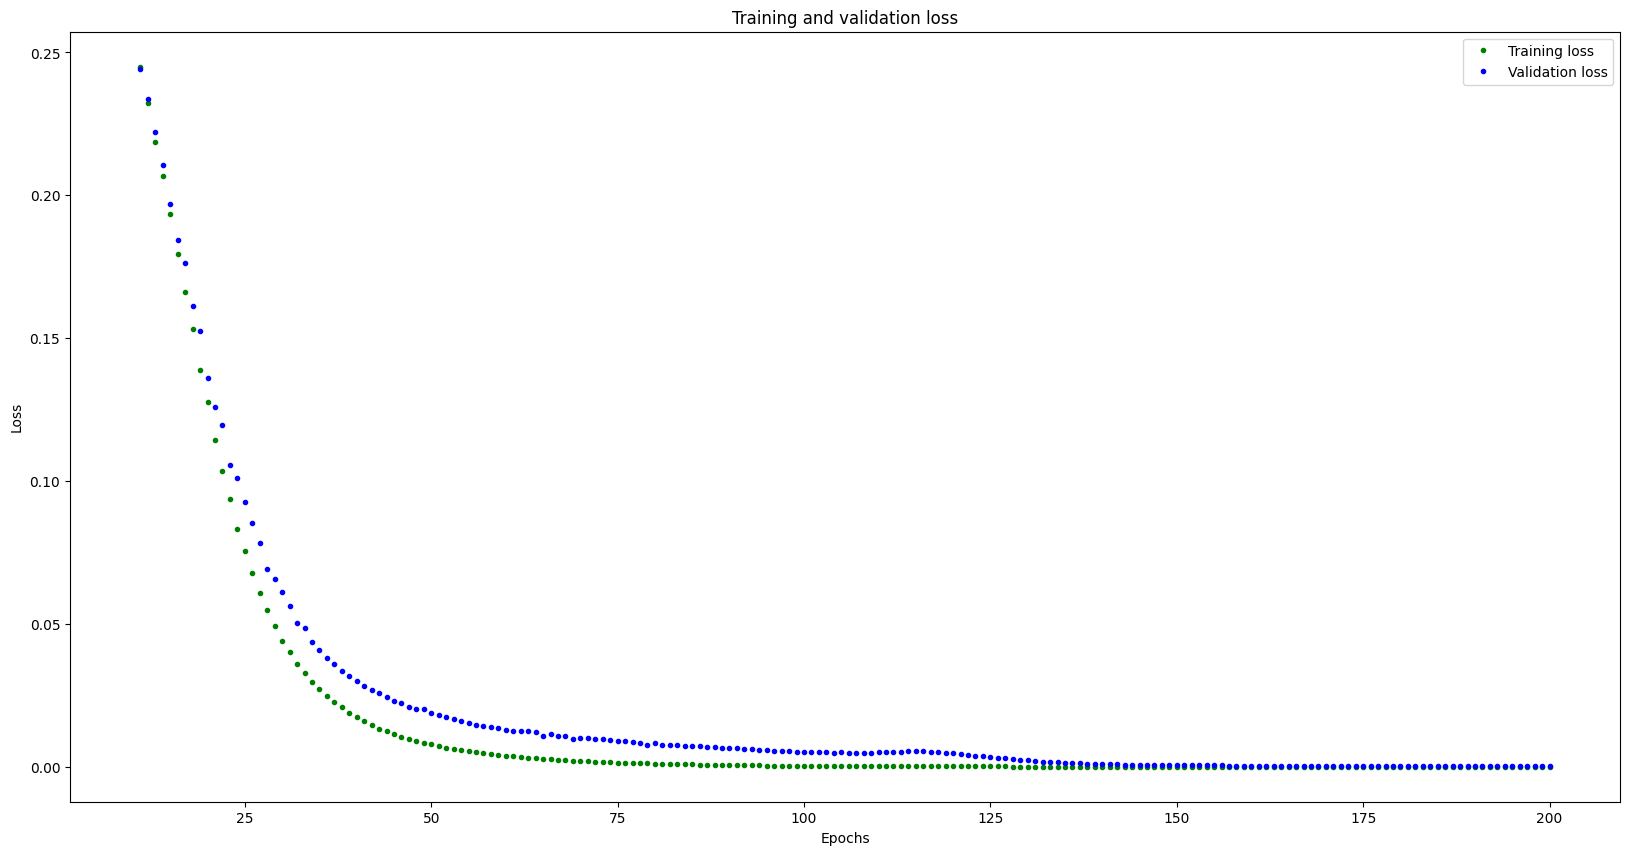

In [33]:
# graph the loss again skipping a bit of the start
SKIP = 10
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Graph the mean absolute error

[Mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) is another metric to judge the performance of the model.



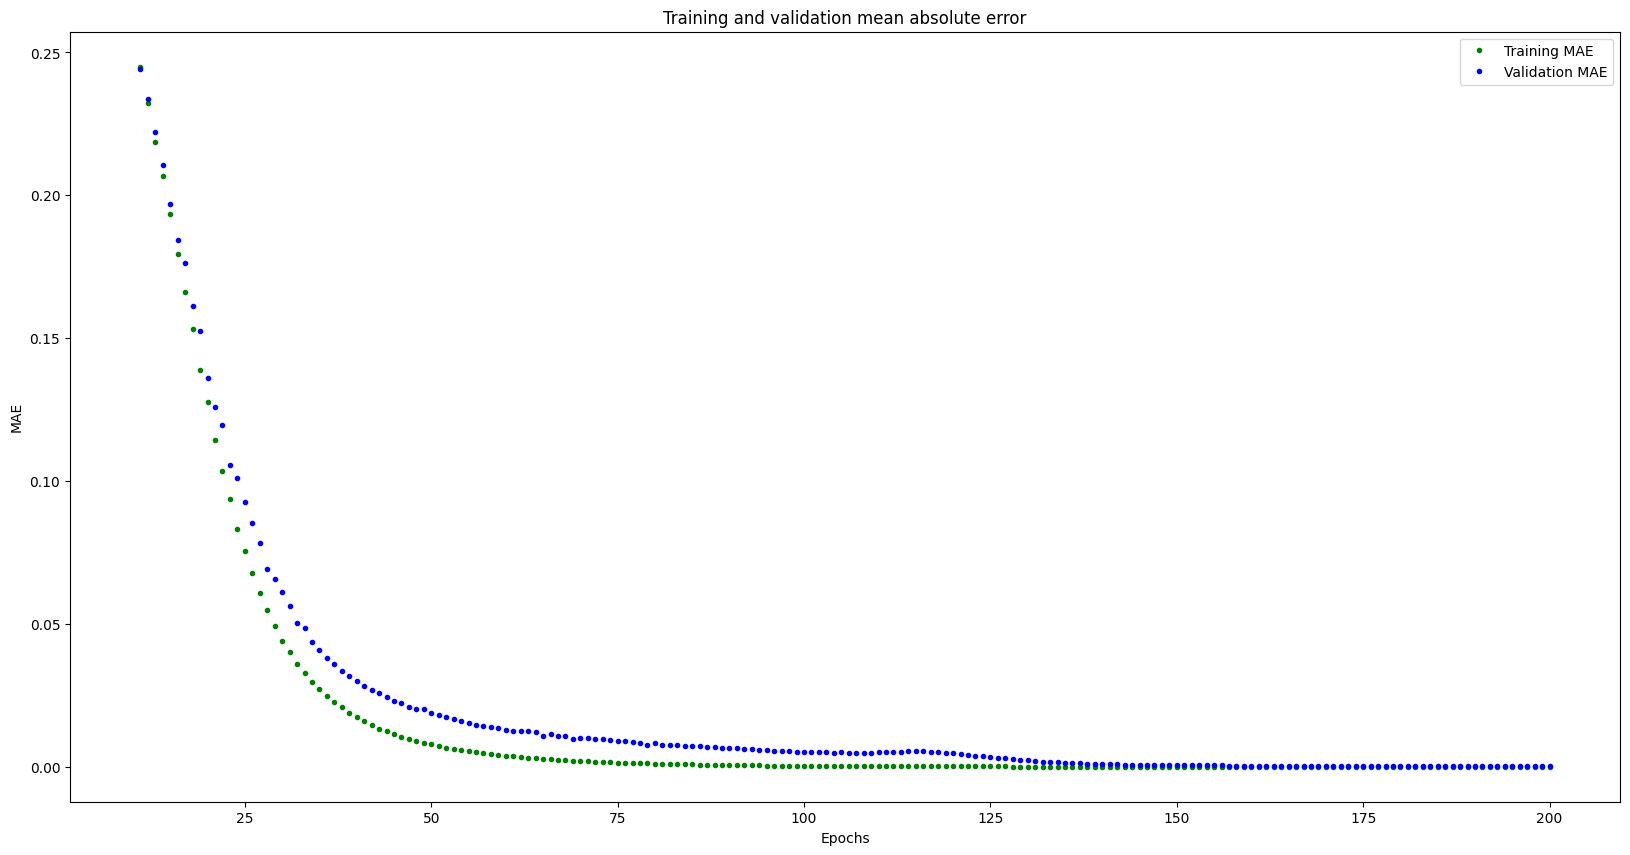

In [34]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


### Run with Test Data
Put our test data into the model and plot the predictions


In [ ]:
inputs_test.shape

(8, 1200)

In [ ]:
predictions

array([[9.97797370e-01, 5.18375287e-10, 4.22951896e-09, 2.20264448e-03],
       [9.99941647e-01, 6.23467884e-14, 5.39669776e-09, 5.83429864e-05],
       [7.57211410e-06, 1.00811925e-02, 2.55531086e-05, 9.89885569e-01],
       [2.54256116e-10, 9.90655005e-01, 2.84261698e-10, 9.34499409e-03],
       [2.64664853e-12, 9.99467254e-01, 2.12920675e-12, 5.32805687e-04],
       [9.99774456e-01, 3.22112367e-12, 3.08355763e-09, 2.25494368e-04],
       [1.55151629e-05, 4.19317931e-03, 3.89512570e-05, 9.95752394e-01],
       [1.92923766e-09, 8.70695236e-15, 9.99902904e-01, 9.70767942e-05]],
      dtype=float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
predictions =
 [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]
actual =
 [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


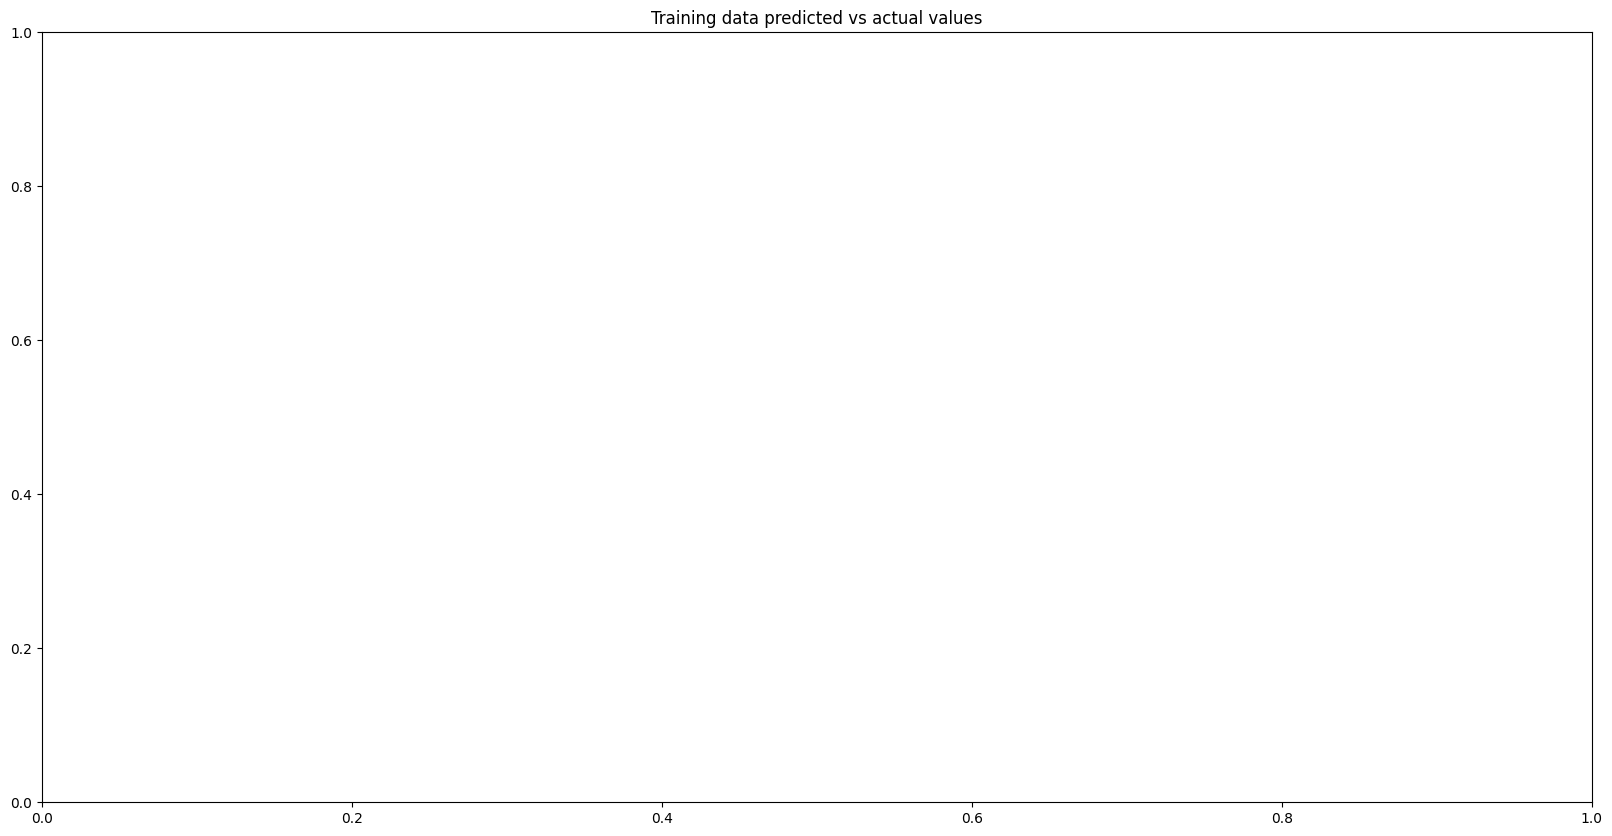

In [23]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

# Plot the predictions along with to the test data
plt.clf()
plt.title('Training data predicted vs actual values')
#plt.plot(inputs_test, outputs_test, 'b.', label='Actual')
#plt.plot(inputs_test, predictions, 'r.', label='Predicted')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



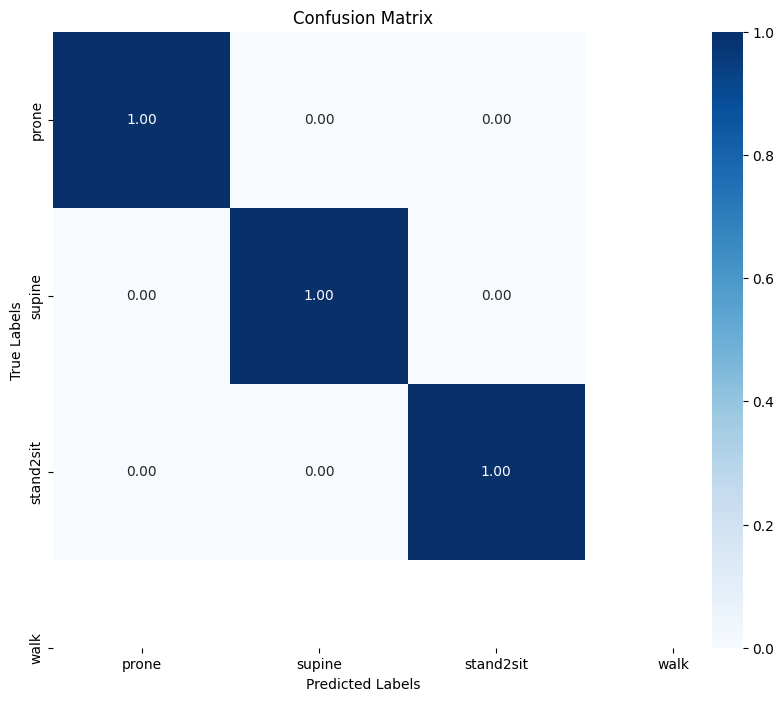

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming model is your trained Keras model, inputs_test is your test data, and outputs_test is the true labels

# Generate predictions
predictions = model.predict(inputs_test)

# If your model output is probabilistic (e.g., softmax), convert the probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# If outputs_test is one-hot encoded, convert to class labels
if len(outputs_test.shape) > 1 and outputs_test.shape[1] > 1:
    true_classes = np.argmax(outputs_test, axis=1)
else:
    true_classes = outputs_test

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(true_classes, predicted_classes, average='weighted')
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(true_classes, predicted_classes, average='weighted')
print(f'Recall: {recall:.4f}')

# Calculate F1-score
f1 = f1_score(true_classes, predicted_classes, average='weighted')
print(f'F1-score: {f1:.4f}')

# Print classification report
report = classification_report(true_classes, predicted_classes)
print('Classification Report:')
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Define class labels, ensuring the number of labels matches the number of classes
class_labels = ["prone", "supine", "stand2sit", "walk"]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
true_classes
#predicted_classes

array([0, 0, 3, 1, 1, 0, 3, 2])

# Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

In [66]:
# Convert the model to the TensorFlow Lite format without quantization

# Specify model to convert
#model = lr

#converter=tf.lite.TFLiteConverter.from_saved_model(model) # doesn't work

converter = tf.lite.TFLiteConverter.from_keras_model(model0)
tflite_model = converter.convert()

# Save the model to disk
open("EPG_20241017_1018_4class_3dof_tf_keras_25hz.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("EPG_20241017_1018_4class_3dof_tf_keras_25hz.tflite")
print("Model is %d bytes" % basic_model_size)



Model is 15112 bytes


In [67]:
#import tensorflow as tf

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="EPG_20241017_1018_4class_3dof_tf_keras_25hz.tflite")

# Allocate tensors
interpreter.allocate_tensors()

# Get the list of operations used in the model


# Get the tensor details
tensor_details = interpreter.get_tensor_details()

print("Tensor details in the model:")
for tensor in tensor_details:
    tensor_name = tensor['name']
    tensor_index = tensor['index']
    tensor_shape = tensor['shape']
    tensor_dtype = tensor['dtype']

    # Print readable tensor information
    print(f"Tensor Index: {tensor_index}, Name: {tensor_name}, Shape: {tensor_shape}, Data Type: {tensor_dtype}")



Tensor details in the model:
Tensor Index: 0, Name: serving_default_dense_3_input:0, Shape: [ 1 75], Data Type: <class 'numpy.float32'>
Tensor Index: 1, Name: arith.constant, Shape: [ 4 15], Data Type: <class 'numpy.float32'>
Tensor Index: 2, Name: arith.constant1, Shape: [15 35], Data Type: <class 'numpy.float32'>
Tensor Index: 3, Name: arith.constant2, Shape: [4], Data Type: <class 'numpy.float32'>
Tensor Index: 4, Name: arith.constant3, Shape: [15], Data Type: <class 'numpy.float32'>
Tensor Index: 5, Name: sequential_1/dense_3/BiasAdd/ReadVariableOp, Shape: [35], Data Type: <class 'numpy.float32'>
Tensor Index: 6, Name: sequential_1/dense_3/MatMul, Shape: [35 75], Data Type: <class 'numpy.float32'>
Tensor Index: 7, Name: sequential_1/dense_3/MatMul;sequential_1/dense_3/Relu;sequential_1/dense_3/BiasAdd, Shape: [ 1 35], Data Type: <class 'numpy.float32'>
Tensor Index: 8, Name: sequential_1/dense_4/MatMul;sequential_1/dense_4/Relu;sequential_1/dense_4/BiasAdd, Shape: [ 1 15], Data Typ

## Encode the Model in an Arduino Header File

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

In [68]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat EPG_20241017_1018_4class_3dof_tf_keras_25hz.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 93,226 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


# Classifying IMU Data

Now it's time to switch back to the tutorial instructions and run our new model on the Arduino Nano 33 BLE Sense to classify the accelerometer and gyroscope data.


In [ ]:
# test with numpy tensor array?


# reshape input array back to original shape

input_dimension = 6
df_inputs = pd.DataFrame(inputs.reshape(16800, input_dimension))

"""  This part is to reverse One-hot encode but not directly applicable here since the "outputs" format is not what I thought.
# define a dictionary that maps column names to original labels
label_dict = {'0': 'currentup', '1': 'currentdown', '2': 'wakeup', '3': 'toggle', '4': 'turnoff'}

reverselabels = np.argmax(outputs, axis=1)
labels = [label_dict[str(i)] for i in reverselabels]
df_outputs=pd.DataFrame(labels)  # outputs are onehot encoded...
"""

# create an new output column in dataframe

#SAMPLES_PER_GESTURE = 119


start_index = 0
last_index = 0
df_formatted_outputs = pd.DataFrame(columns=['label'])
for gesture_index in range(NUM_GESTURES):
  last_index = (gesture_index+1) * SAMPLES_PER_GESTURE*num_recordings-1
  df_inputs.loc[start_index:last_index,'label'] = GESTURES[gesture_index]
  start_index = last_index + 1


df_outputs = df_inputs['label']
df_inputs = df_inputs.drop('label', axis=1 )

x_train, x_test, y_train, y_test = train_test_split(df_inputs, df_outputs, test_size=0.2, shuffle=True, random_state=42)



In [ ]:
#df_idle = pd.read_csv(dataRoot + "idle" + ".csv")
df_toggle = pd.read_csv(dataRoot + "toggle" + ".csv")
df_currentup = pd.read_csv(dataRoot + "currentup" + ".csv")
df_currentdown = pd.read_csv(dataRoot + "currentdown" + ".csv")
df_turnoff = pd.read_csv(dataRoot + "turnoff" + ".csv")
df_wakeup = pd.read_csv(dataRoot + "wakeup" + ".csv")
#df_sleepready = pd.read_csv(dataRoot + "sleepready" + ".csv")

In [ ]:
#df_idle = pd.read_csv(dataRoot + "idle" + ".csv")
df_heeltap = pd.read_csv(dataRoot + "heelTap" + ".csv")
df_prone = pd.read_csv(dataRoot + "prone" + ".csv")
df_sit2prone = pd.read_csv(dataRoot + "sit2prone" + ".csv")
df_sit2stand = pd.read_csv(dataRoot + "sit2stand" + ".csv")
df_sit2supine = pd.read_csv(dataRoot + "sit2supine" + ".csv")
df_stand2sit = pd.read_csv(dataRoot + "stand2sit" + ".csv")
df_standing = pd.read_csv(dataRoot + "standing" + ".csv")
df_supine = pd.read_csv(dataRoot + "supine" + ".csv")
df_waistCircular = pd.read_csv(dataRoot + "waistCircular" + ".csv")
df_walk60 = pd.read_csv(dataRoot + "walk60" + ".csv")

In [ ]:
df_prone = pd.read_csv(dataRoot + "prone" + ".csv")
df_stand2sit = pd.read_csv(dataRoot + "stand2sit" + ".csv")
df_walk = pd.read_csv(dataRoot + "walk" + ".csv")
df_supine = pd.read_csv(dataRoot + "supine" + ".csv")


In [ ]:

#df_idle['label'] = "idle"
df_toggle['label'] = "toggle"
df_currentup['label'] = "currentup"
df_currentdown['label'] = "currentdown"
df_turnoff['label'] = "turnoff"
df_wakeup['label'] = "wakeup"
#df_sleepready['label'] = "sleepready"

# append all dataframe into one
dfs = [df_currentup, df_currentdown, df_wakeup, df_toggle, df_turnoff]
df_all = pd.concat(dfs, axis=0, ignore_index=True)
df_all


In [ ]:

df_prone['label'] = "prone"
df_stand2sit['label'] = "stand2sit"
df_supine['label'] = "supine"
df_walk['label'] = "walk"



# append all dataframe into one
dfs = [df_prone, df_stand2sit,  df_supine,  df_walk]
df_all = pd.concat(dfs, axis=0, ignore_index=True)
df_all


,aX,aY,aZ,gX,gY,gZ,label
0,0.510,-7.995,1.077,7.14,-9.03,-1.61,prone
1,0.598,-7.968,1.133,6.23,-6.51,-2.24,prone
2,0.569,-7.989,1.113,5.88,-5.60,-2.45,prone
3,0.546,-8.012,1.108,5.18,-4.83,-2.52,prone
4,0.596,-8.005,1.158,3.78,-3.36,-2.59,prone
...,...,...,...,...,...,...,...
7995,-8.072,-0.191,-0.344,10.78,-1.26,-5.81,walk
7996,-8.455,-0.127,-0.204,10.78,2.94,-7.84,walk
7997,-8.784,-0.070,-0.078,11.69,4.76,-11.20,walk
7998,-8.948,-0.059,-0.029,12.32,3.01,-13.58,walk


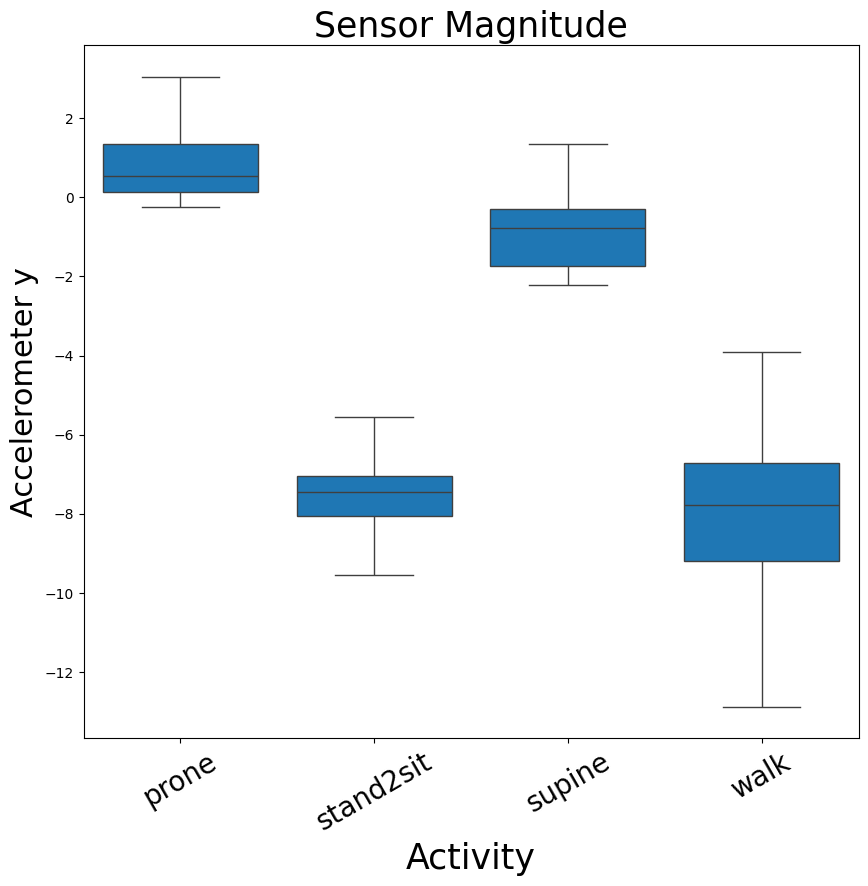

In [ ]:
import seaborn as sns

plt.figure(figsize=(10,9))
sns.boxplot(x='label', y='aX',data=df_all, showfliers=False, saturation=1)
# plt.axhline(y=-0.7, xmin=0.1, xmax=0.9,dashes=(5,5), c='g')
# plt.axhline(y=-0.05, xmin=0.4, dashes=(5,5), c='m')
plt.title("Sensor Magnitude", fontsize = 25)
plt.xlabel("Activity", size=25)
plt.ylabel('Accelerometer y', size=22)
plt.xticks(rotation=30, fontsize=20)
plt.show()

# Visualizing data after reducing dimentions with T-SNE

In [ ]:
def perform_tsne(X_data, y_data, perplexities, n_iter=100, img_name_prefix='t-sne'):

    for index,perplexity in enumerate(perplexities):
        # perform t-sne
        X_reduced = TSNE(verbose=2, perplexity=perplexity).fit_transform(X_data)

        # prepare the data for seaborn
        print('Creating plot for this t-sne visualization..')
        df = pd.DataFrame({'x':X_reduced[:,0], 'y':X_reduced[:,1] ,'label':y_data})

        # draw the plot in appropriate place in the grid
        sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False,\
                   palette="Set1",markers= ['^', 'v', 's', 'o'])
                  #  palette="Set1",markers= ['^', 'v', 's', 'o', '1', 'P', '*', 'X', 'D', '+'])
        plt.title("perplexity : {} and max_iter : {}".format(perplexity, n_iter))
        img_name = img_name_prefix + '_perp_{}_iter_{}.png'.format(perplexity, n_iter)
        print('saving this plot as image in present working directory...')
        plt.savefig(img_name)
        plt.show()
        print('Done')

### Principal Component Analysis

Principal component analysis, or PCA, is a statistical technique to convert high dimensional data to low dimensional data by selecting the most important features that capture maximum information about the dataset. The features are selected on the basis of variance that they cause in the output. The feature that causes highest variance is the first principal component. The feature that is responsible for second highest variance is considered the second principal component, and so on. It is important to mention that principal components do not have any correlation with each other.

There are two main advantages of dimensionality reduction with PCA.

* The training time of the algorithms reduces significantly with less number of features.
* It is not always possible to analyze data in high dimensions. For instance if there are 100 features in a dataset. Total number of scatter plots required to visualize the data would be 100(100-1)2 = 4950. Practically it is not possible to analyze data this way.

In [ ]:
# PCA
# data = pd.concat([train_data, test_data])
#data = train_data.sample(frac=1)
# f_df = data.loc[:, data.columns.str.contains('^f|^s|^a|^A')]
# t_df = data.loc[:, data.columns.str.contains('^t|^s|^a|^A')]




# X = data.drop(['subject', 'Activity'], axis=1)
# y = data['Activity']

# X_f = f_df.drop(['subject', 'Activity'], axis=1)
# y_f = f_df['Activity']

# X_t = t_df.drop(['subject', 'Activity'], axis=1)
# y_t = t_df['Activity']


pca = PCA(n_components=0.99)
pca.fit(X)
x_reduced = pca.transform(X)

# print('Frequency components number is {} Time components number is {}'.format(X_f.shape[1], X.shape[1] - X_f.shape[1]))
print('Original number of features {} Reduced number of features {}'.format(X.shape[1], x_reduced.shape[1]))

x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(x_reduced, y, test_size=0.2, shuffle=True, random_state=42)
# x_train_f, x_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.2, shuffle=True, random_state=42)
# x_train_t, x_test_t, y_train_t, y_test_t = train_test_split(X_t, y_t, test_size=0.2, shuffle=True, random_state=42)




NameError: name 'X' is not defined

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.011s...
[t-SNE] Computed neighbors for 8000 samples in 0.375s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.305899
[t-SNE] Computed conditional probabilities in 0.168s
[t-SNE] Iteration 50: error = 87.9485168, gradient norm = 0.0464923 (50 iterations in 4.673s)
[t-SNE] Iteration 100: error = 76.7752914, gradient norm = 0.0160595 (50 iterations in 3.333s)
[t-SNE] Iteration 150: error = 72.6795959, gradient norm = 0

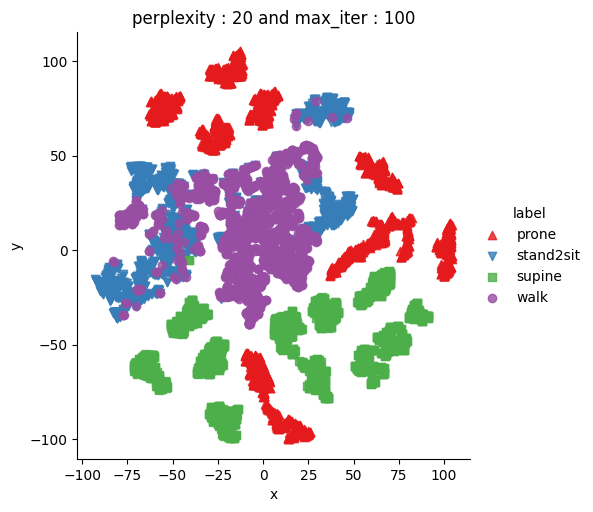

Done


In [ ]:
X_pre_tsne = df_all.drop(['label'], axis=1)
y_pre_tsne = df_all['label']


perform_tsne(X_data = X_pre_tsne,y_data=y_pre_tsne, perplexities =[20])

In [ ]:
X = X_pre_tsne
y = y_pre_tsne
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)


In [ ]:
kernal_evals = dict()
def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    train_accuracy = metrics.accuracy_score(y_train, model.predict(X_train))
    test_accuracy = metrics.accuracy_score(y_test, model.predict(X_test))

    train_precision = metrics.precision_score(y_train, model.predict(X_train), average='micro')
    test_precision = metrics.precision_score(y_test, model.predict(X_test), average='micro')

    train_recall = metrics.recall_score(y_train, model.predict(X_train), average='micro')
    test_recall = metrics.recall_score(y_test, model.predict(X_test), average='micro')

    kernal_evals[str(name)] = [train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall]
    print("Training Accuracy " + str(name) + " {}  Test Accuracy ".format(train_accuracy*100) + str(name) + " {}".format(test_accuracy*100))
    print("Training Precesion " + str(name) + " {}  Test Precesion ".format(train_precision*100) + str(name) + " {}".format(test_precision*100))
    print("Training Recall " + str(name) + " {}  Test Recall ".format(train_recall*100) + str(name) + " {}".format(test_recall*100))

    actual = y_test
    predicted = model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(actual, predicted, normalize='true')
    #cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['CurrentUp', 'CurrentDown', 'Wakeup', 'Toggle'
    #, 'TurnOff'])
    # cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['heelTap', 'prone', 'sit2prone', 'sit2stand'
    # , 'sit2supine', 'stand2sit', 'standing',  'supine', 'waistCircular', 'walk60'])
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['prone','stand2sit', 'supine','walk'])
    fig, ax = plt.subplots(figsize=(10,10))
    ax.grid(False)
    cm_display.plot(ax=ax)


In [ ]:
# try with this specific format for other ML models

num_train_labels = np.argmax(outputs_train, axis=1)
reverse_train_labels = [GESTURES[i] for i in num_train_labels]
reverse_train_labels

outputs_reverse_train = reverse_train_labels


num_test_labels = np.argmax(outputs_test, axis=1)
reverse_test_labels = [GESTURES[i] for i in num_test_labels]
reverse_test_labels
outputs_reverse_test = reverse_test_labels



x_train = inputs_train
x_test = inputs_test
y_train = outputs_reverse_train
y_test = outputs_reverse_test

In [ ]:
x_train

,aX,aY,aZ,gX,gY,gZ
1467,2.838,-7.148,2.552,0.91,-2.45,-0.77
5768,1.194,7.047,3.508,1.40,-2.94,-1.47
5714,1.230,6.984,3.562,0.49,-1.68,-1.05
1578,2.713,-7.148,2.546,0.84,-2.31,-0.63
6958,-7.298,-1.437,0.067,30.73,24.85,-17.43
...,...,...,...,...,...,...
5226,-1.740,7.624,-1.383,1.19,-1.47,-3.57
5390,-1.756,7.615,-1.393,1.47,-2.73,-2.52
860,2.025,-7.742,1.503,1.75,-2.80,-0.21
7603,-7.818,0.295,-0.363,5.39,-18.62,-3.85


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy Logistic Regression 92.671875  Test Accuracy Logistic Regression 93.25
Training Precesion Logistic Regression 92.671875  Test Precesion Logistic Regression 93.25
Training Recall Logistic Regression 92.671875  Test Recall Logistic Regression 93.25


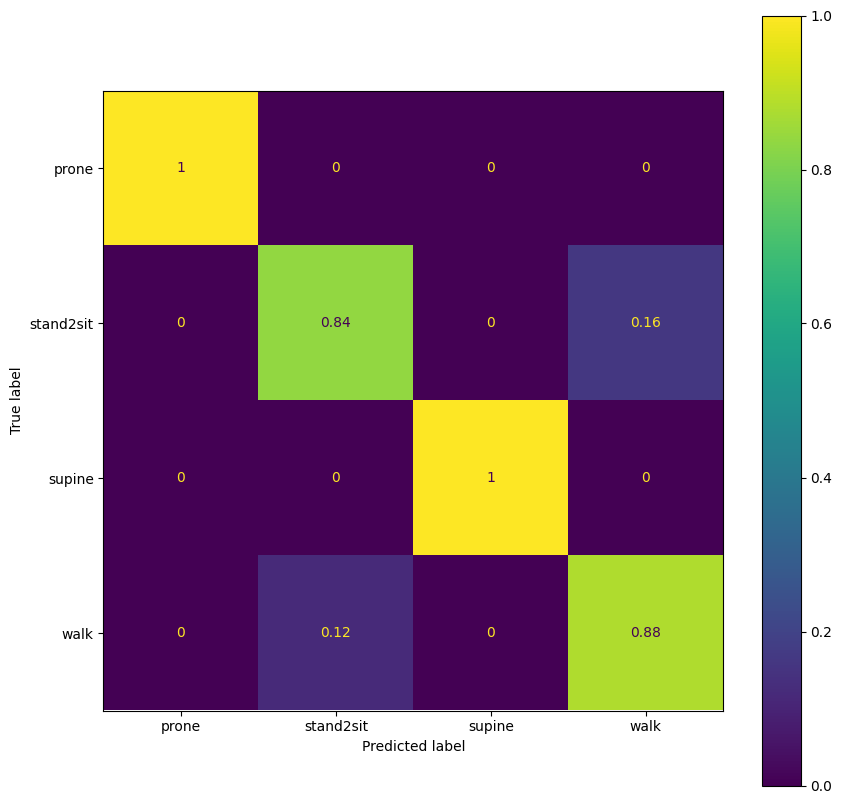

In [ ]:

#%%
# build other ML models
lr = LogisticRegression().fit(x_train, y_train)
evaluate_classification(lr, "Logistic Regression", x_train, x_test, y_train, y_test)


Training Accuracy LinearDiscriminantAnalysis 89.875  Test Accuracy LinearDiscriminantAnalysis 90.0
Training Precesion LinearDiscriminantAnalysis 89.875  Test Precesion LinearDiscriminantAnalysis 90.0
Training Recall LinearDiscriminantAnalysis 89.875  Test Recall LinearDiscriminantAnalysis 90.0


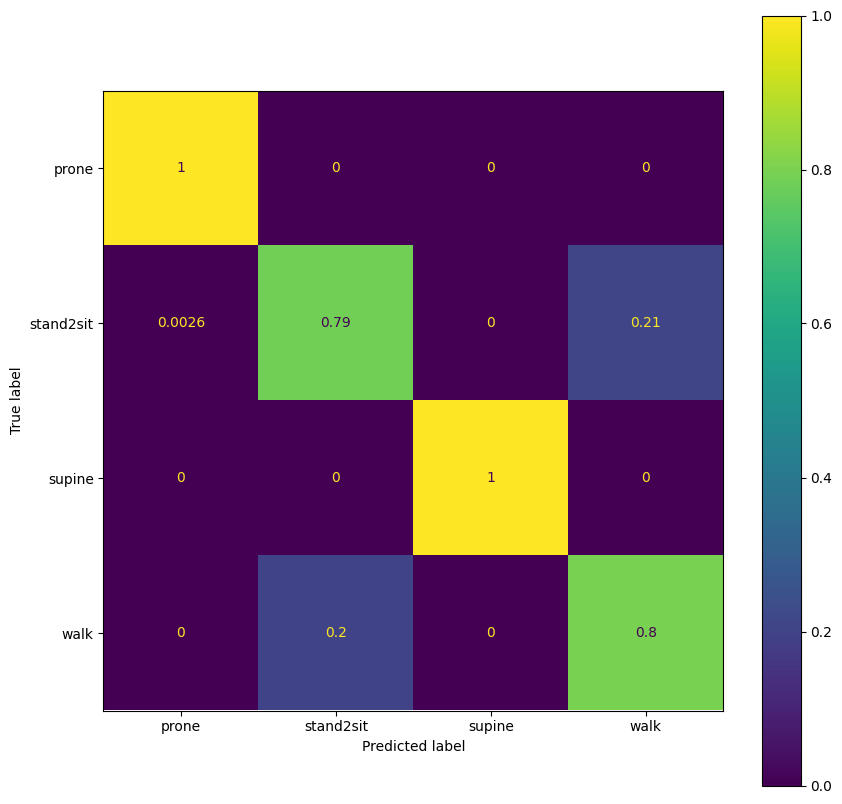

In [ ]:
lda = LinearDiscriminantAnalysis().fit(x_train, y_train)
evaluate_classification(lda, "LinearDiscriminantAnalysis", x_train, x_test, y_train, y_test)

Training Accuracy KNeighborsClassifier 95.5625  Test Accuracy KNeighborsClassifier 94.75
Training Precesion KNeighborsClassifier 95.5625  Test Precesion KNeighborsClassifier 94.75
Training Recall KNeighborsClassifier 95.5625  Test Recall KNeighborsClassifier 94.75


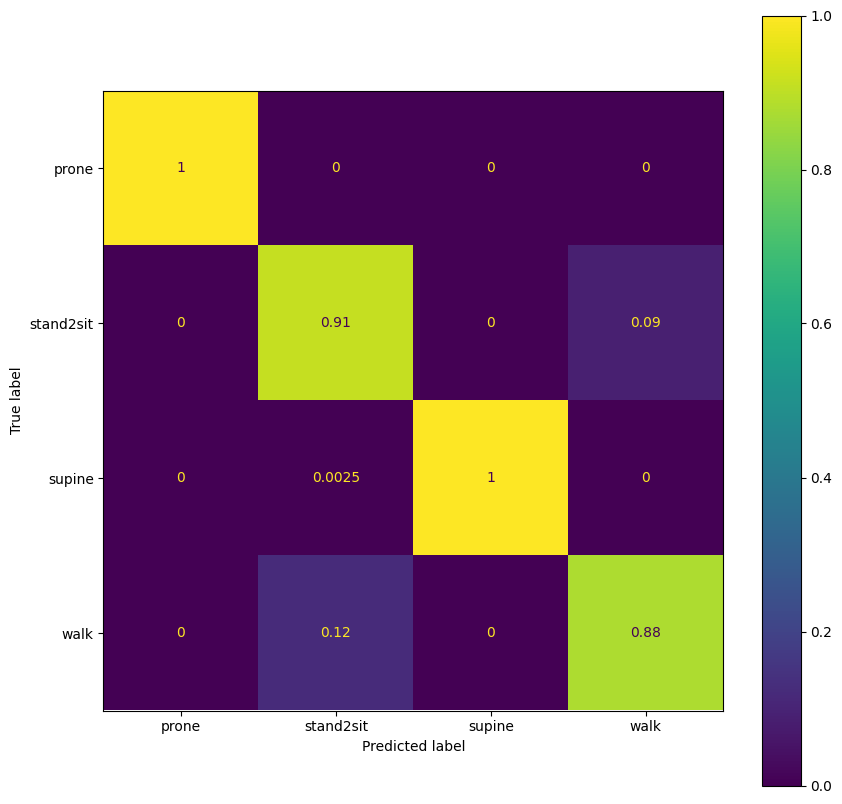

In [ ]:
knn = KNeighborsClassifier(n_neighbors=30).fit(x_train, y_train)
evaluate_classification(knn, "KNeighborsClassifier", x_train, x_test, y_train, y_test)

Training Accuracy GaussianNB 92.171875  Test Accuracy GaussianNB 92.625
Training Precesion GaussianNB 92.171875  Test Precesion GaussianNB 92.625
Training Recall GaussianNB 92.171875  Test Recall GaussianNB 92.625


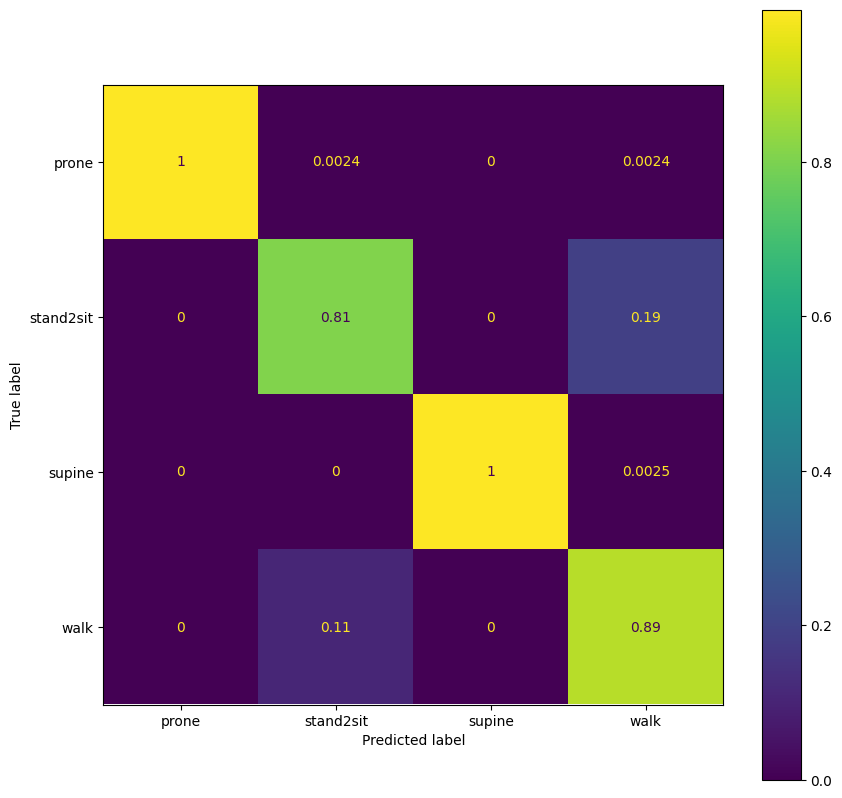

In [ ]:
gnb = GaussianNB().fit(x_train, y_train)
evaluate_classification(gnb, "GaussianNB", x_train, x_test, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Accuracy Linear SVC(LBasedImpl) 86.9375  Test Accuracy Linear SVC(LBasedImpl) 87.0625
Training Precesion Linear SVC(LBasedImpl) 86.9375  Test Precesion Linear SVC(LBasedImpl) 87.0625
Training Recall Linear SVC(LBasedImpl) 86.9375  Test Recall Linear SVC(LBasedImpl) 87.0625


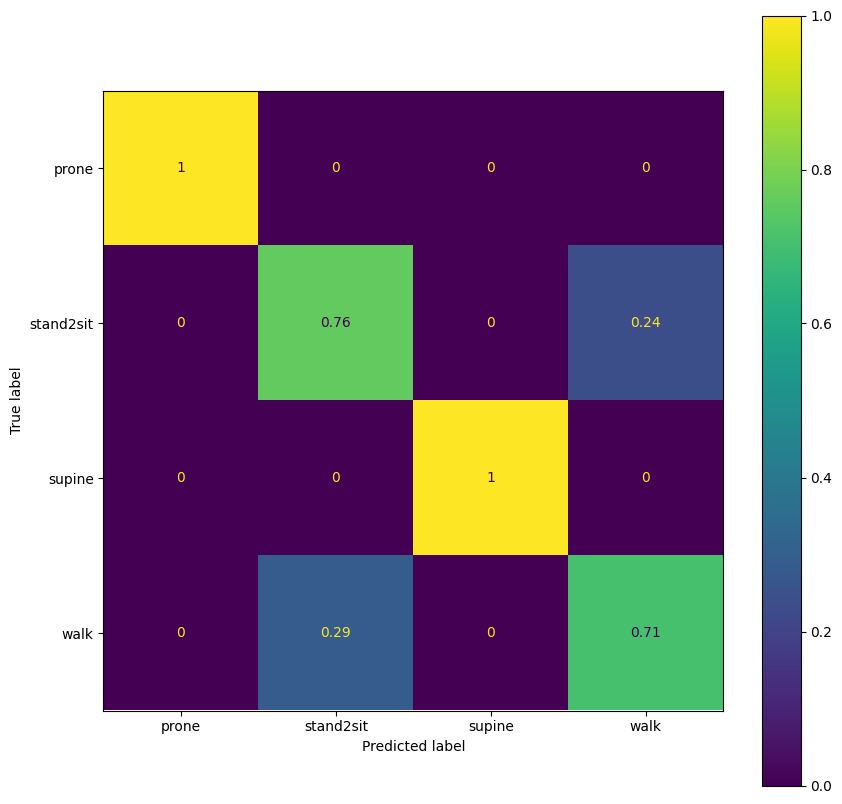

In [ ]:
lin_svc = svm.LinearSVC().fit(x_train, y_train)
evaluate_classification(lin_svc, "Linear SVC(LBasedImpl)", x_train, x_test, y_train, y_test)

Training Accuracy RBF SVC 95.921875  Test Accuracy RBF SVC 95.4375
Training Precesion RBF SVC 95.921875  Test Precesion RBF SVC 95.4375
Training Recall RBF SVC 95.921875  Test Recall RBF SVC 95.4375


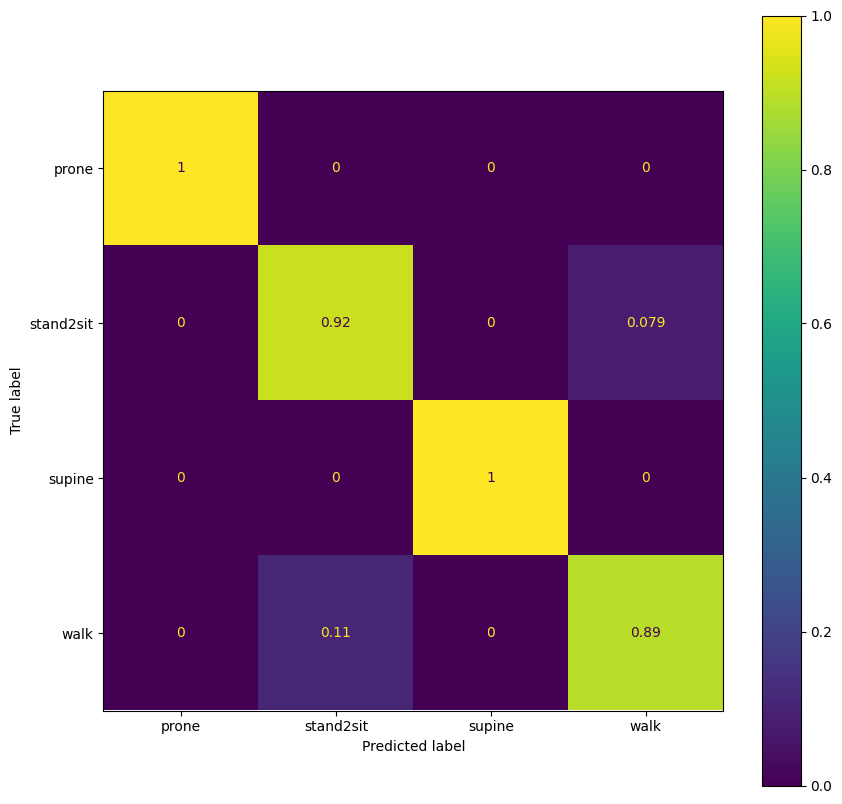

In [ ]:
rbf = svm.SVC(kernel='rbf').fit(x_train, y_train)
evaluate_classification(rbf, "RBF SVC", x_train, x_test, y_train, y_test)

Training Accuracy DecisionTreeClassifier 100.0  Test Accuracy DecisionTreeClassifier 98.3125
Training Precesion DecisionTreeClassifier 100.0  Test Precesion DecisionTreeClassifier 98.3125
Training Recall DecisionTreeClassifier 100.0  Test Recall DecisionTreeClassifier 98.3125


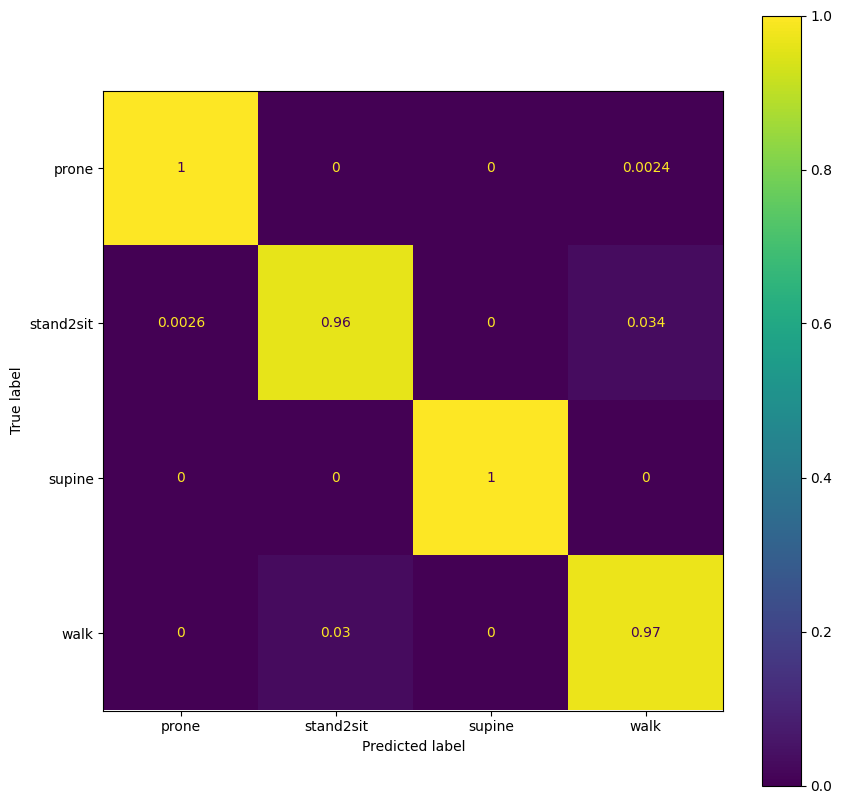

In [ ]:
tdt = DecisionTreeClassifier().fit(x_train, y_train)
evaluate_classification(tdt, "DecisionTreeClassifier", x_train, x_test, y_train, y_test)

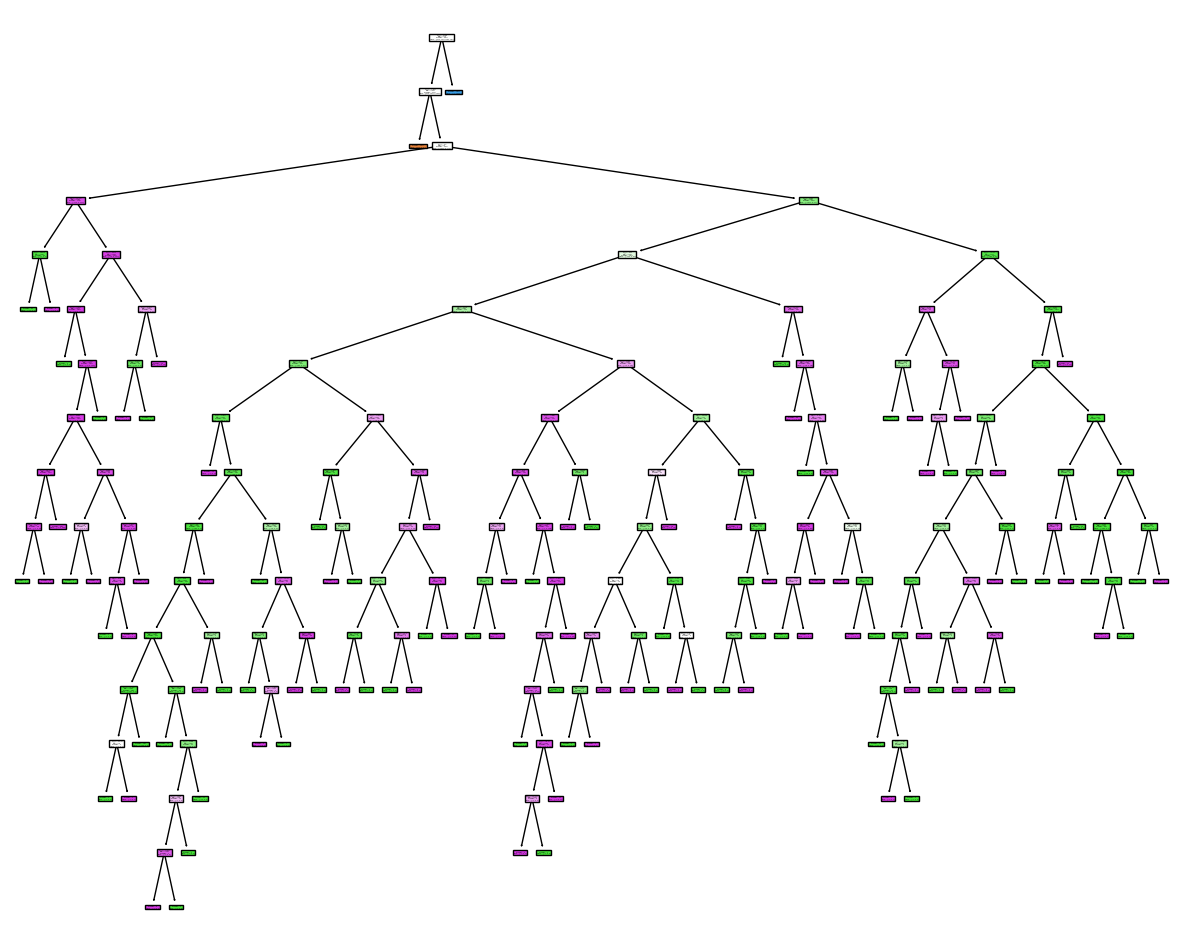

In [ ]:
fig = plt.figure(figsize=(15,12))
tree.plot_tree(tdt , filled=True)
plt.show()

Training Accuracy RandomForestClassifier 100.0  Test Accuracy RandomForestClassifier 99.25
Training Precesion RandomForestClassifier 100.0  Test Precesion RandomForestClassifier 99.25
Training Recall RandomForestClassifier 100.0  Test Recall RandomForestClassifier 99.25


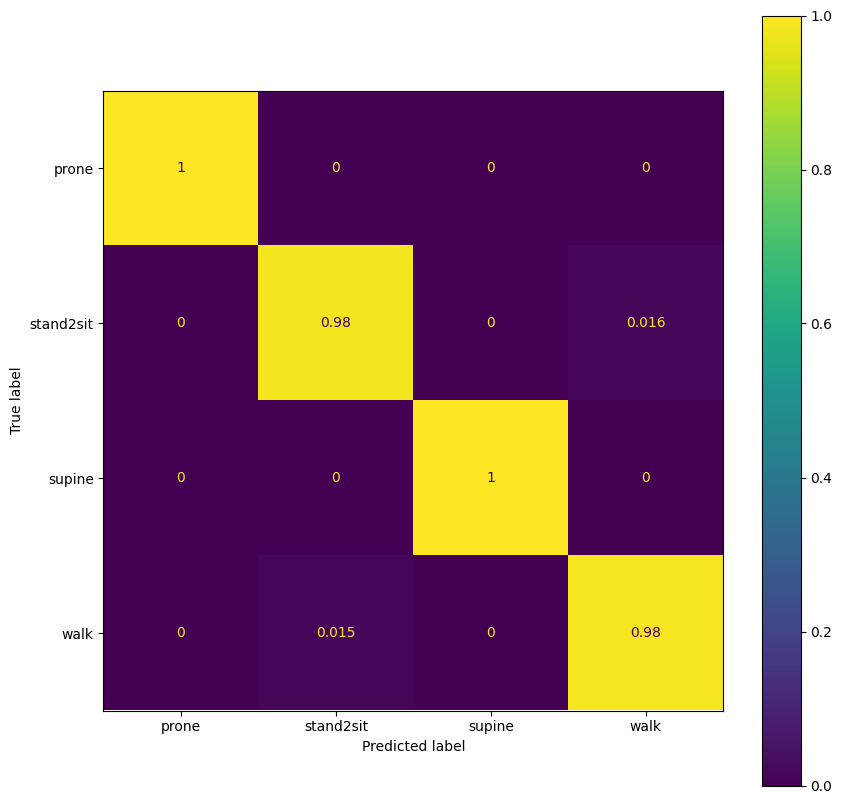

In [ ]:
rf = RandomForestClassifier().fit(x_train, y_train)
evaluate_classification(rf, "RandomForestClassifier", x_train, x_test, y_train, y_test)

Training Accuracy XGBClassifier 98.140625  Test Accuracy XGBClassifier 97.6875
Training Precesion XGBClassifier 98.140625  Test Precesion XGBClassifier 97.6875
Training Recall XGBClassifier 98.140625  Test Recall XGBClassifier 97.6875


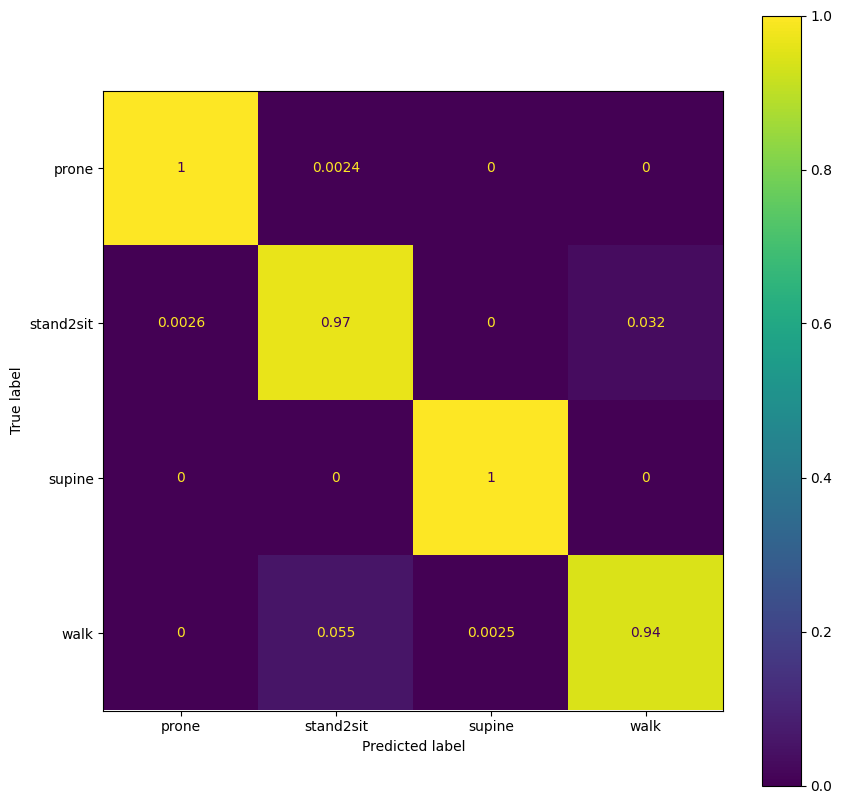

In [ ]:
le = preprocessing.LabelEncoder().fit(y_train)
y_xgb_train = le.transform(y_train)
y_xgb_test = le.transform(y_test)

xgb_params = {'n_estimators': 100,
              'learning_rate': 0.2,
              'subsample': 0.927,
              'colsample_bytree': 0.88,
              'max_depth': 5,
              'booster': 'gbtree',
              'reg_lambda': 38,
              'reg_alpha': 32,
              'random_state': 12}
xgb = XGBClassifier(**xgb_params).fit(x_train, y_xgb_train)
evaluate_classification(xgb, "XGBClassifier", x_train, x_test, y_xgb_train, y_xgb_test)